<font size="+3"><strong>Air Quality in Dar es Salaam 🇹🇿</strong></font>

In [1]:
import warnings

import wqet_grader

warnings.simplefilter(action="ignore", category=FutureWarning)
wqet_grader.init("Project 3 Assessment")

In [2]:
# Import libraries here
import inspect
import time
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from IPython.display import VimeoVideo
from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg

In [8]:
from pprint import PrettyPrinter

# Prepare Data

## Connect

**Task 3.5.1:** Connect to MongoDB server running at host `"localhost"` on port `27017`. Then connect to the `"air-quality"` database and assign the collection for Dar es Salaam to the variable name `dar`.

In [5]:
client = MongoClient(host="localhost", port=27017)
db = client["air-quality"]
dar = db["dar-es-salaam"]

In [4]:
for collection in db.list_collections():
    print(collection['name'])

system.views
nairobi
system.buckets.nairobi
dar-es-salaam
system.buckets.dar-es-salaam
lagos
system.buckets.lagos


In [6]:
wqet_grader.grade("Project 3 Assessment", "Task 3.5.1", [dar.name])

## Explore

**Task 3.5.2:** Determine the numbers assigned to all the sensor sites in the Dar es Salaam collection. Your submission should be a list of integers. 

In [10]:
pp = PrettyPrinter(indent=2)

In [11]:
result = dar.find_one({}) #gives one record in nairobi collection
pp.pprint(result)

{ 'P1': 24.3,
  '_id': ObjectId('6245caa44801d208c4ea9587'),
  'metadata': { 'lat': -6.818,
                'lon': 39.285,
                'measurement': 'P1',
                'sensor_id': 29,
                'sensor_type': 'SDS011',
                'site': 11},
  'timestamp': datetime.datetime(2018, 1, 1, 0, 0, 4, 53000)}


In [14]:
sites = dar.distinct("metadata.site")
sites

[23, 11]

In [15]:
wqet_grader.grade("Project 3 Assessment", "Task 3.5.2", sites)

**Task 3.5.3:** Determine which site in the Dar es Salaam collection has the most sensor readings (of any type, not just PM2.5 readings). You submission `readings_per_site` should be a list of dictionaries that follows this format:

```
[{'_id': 6, 'count': 70360}, {'_id': 29, 'count': 131852}]
```

Note that the values here ☝️ are from the Nairobi collection, so your values will look different. 

In [16]:
dar.count_documents({"metadata.site": 23})

60020

In [17]:
dar.count_documents({"metadata.site": 11})

138412

In [23]:
result = dar.find({"metadata.measurement": "P2.5"}).limit(5) 
pp.pprint(list(result))

[]


In [18]:
readings_per_site = [{'_id':23, 'count': dar.count_documents({"metadata.site": 23})},
         {'_id':11, 'count': dar.count_documents({"metadata.site": 11})}]
readings_per_site

[{'_id': 23, 'count': 60020}, {'_id': 11, 'count': 138412}]

In [19]:
wqet_grader.grade("Project 3 Assessment", "Task 3.5.3", readings_per_site)

## Import

**Task 3.5.4:** (5 points) Create a `wrangle` function that will extract the PM2.5 readings from the site that has the most total readings in the Dar es Salaam collection. Your function should do the following steps:

1. Localize reading time stamps to the timezone for `"Africa/Dar_es_Salaam"`.
2. Remove all outlier PM2.5 readings that are above 100. 
3. Resample the data to provide the mean PM2.5 reading for each hour.
4. Impute any missing values using the forward-will method. 
5. Return a Series `y`. 

In [24]:
def wrangle(collection):

    results = collection.find(
        {"metadata.site": 11, "metadata.measurement": "P2"}, ## 11 has the most count
        projection={"P2": 1, "timestamp": 1, "_id": 0},
    )

    # Read results into DataFrame
    df = pd.DataFrame(list(results)).set_index("timestamp")

    # Localize timezone
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Dar_es_Salaam")

    # Remove outliers
    df = df[df["P2"] < 100]

    # Resample and forward-fill
    y = df["P2"].resample("1H").mean().fillna(method="ffill")

    return y

Use your `wrangle` function to query the `dar` collection and return your cleaned results.

In [25]:
y = wrangle(dar)
y.head()

timestamp
2018-01-01 03:00:00+03:00    9.456327
2018-01-01 04:00:00+03:00    9.400833
2018-01-01 05:00:00+03:00    9.331458
2018-01-01 06:00:00+03:00    9.528776
2018-01-01 07:00:00+03:00    8.861250
Freq: H, Name: P2, dtype: float64

In [29]:
y.info()

AttributeError: 'Series' object has no attribute 'info'

In [26]:

wqet_grader.grade("Project 3 Assessment", "Task 3.5.4", wrangle(dar))

## Explore Some More

**Task 3.5.5:** Create a time series plot of the readings in `y`. Label your x-axis `"Date"` and your y-axis `"PM2.5 Level"`. Use the title `"Dar es Salaam PM2.5 Levels"`.

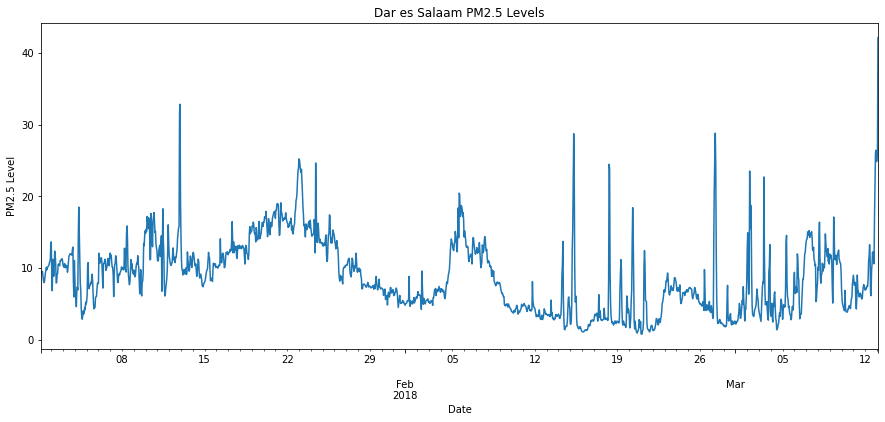

In [30]:
fig, ax = plt.subplots(figsize=(15, 6))

y.plot(  #used y instead of y["P2"] since our y is a pd Series
    xlabel="Date",
    ylabel="PM2.5 Level",
    title="Dar es Salaam PM2.5 Levels",
)


# Don't delete the code below 👇
plt.savefig("images/3-5-5.png", dpi=150)


In [31]:
with open("images/3-5-5.png", "rb") as file:
    wqet_grader.grade("Project 3 Assessment", "Task 3.5.5", file)

**Task 3.5.6:** Plot the rolling average of the readings in `y`. Use a window size of `168` (the number of hours in a week). Label your x-axis `"Date"` and your y-axis `"PM2.5 Level"`. Use the title `"Dar es Salaam PM2.5 Levels, 7-Day Rolling Average"`.

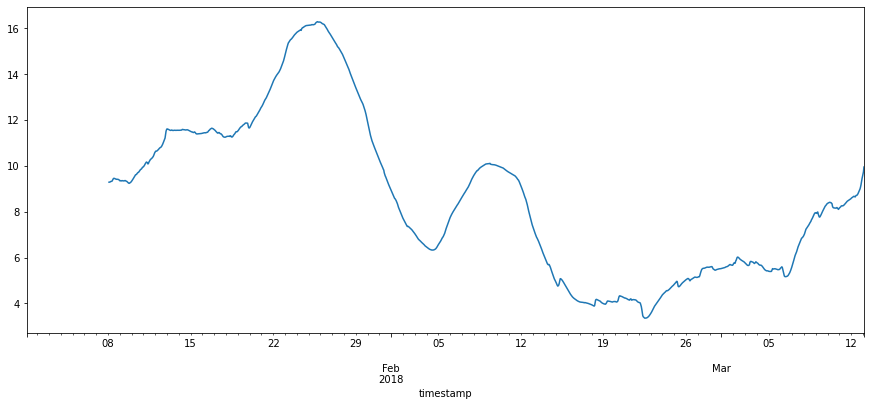

In [32]:
fig, ax = plt.subplots(figsize=(15, 6))

y.rolling(168).mean().plot(ax=ax)

plt.xlabel="Date"
plt.ylabel="PM2.5 Level"
plt.title="Dar es Salaam PM2.5 Levels",


# Don't delete the code below 👇
plt.savefig("images/3-5-6.png", dpi=150)


In [33]:
with open("images/3-5-6.png", "rb") as file:
    wqet_grader.grade("Project 3 Assessment", "Task 3.5.6", file)

**Task 3.5.7:** Create an ACF plot for the data in `y`. Be sure to label the x-axis as `"Lag [hours]"` and the y-axis as `"Correlation Coefficient"`. Use the title `"Dar es Salaam PM2.5 Readings, ACF"`.

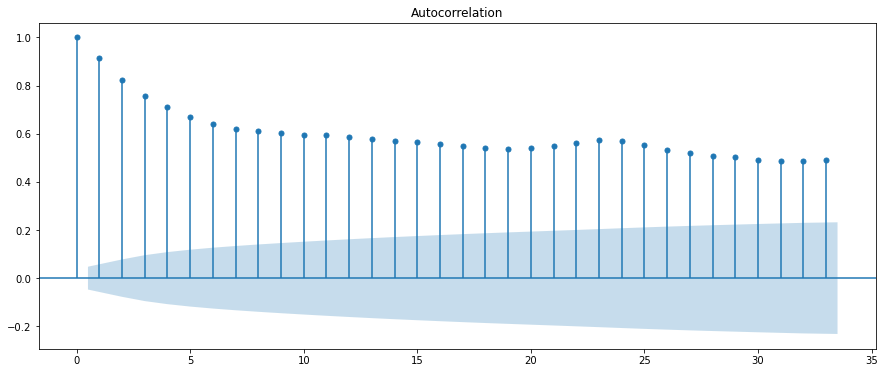

In [35]:
fig, ax = plt.subplots(figsize=(15, 6))

plot_acf(y, ax=ax)
plt.xlabel= "Lag [hours]"
plt.ylabel = "Correlation Coefficient"
plt.title = "Dar es Salaam PM2.5 Readings, ACF"

# Don't delete the code below 👇
plt.savefig("images/3-5-7.png", dpi=150)


In [36]:
with open("images/3-5-7.png", "rb") as file:
    wqet_grader.grade("Project 3 Assessment", "Task 3.5.7", file)

**Task 3.5.8:** Create an PACF plot for the data in `y`. Be sure to label the x-axis as `"Lag [hours]"` and the y-axis as `"Correlation Coefficient"`. Use the title `"Dar es Salaam PM2.5 Readings, PACF"`.

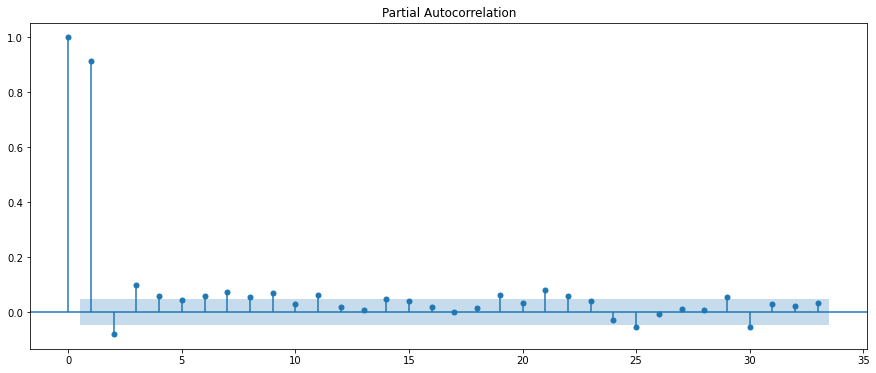

In [38]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel= "Lag [hours]"
plt.ylabel = "Correlation Coefficient"
plt.title = "Dar es Salaam PM2.5 Readings, PACF"

# Don't delete the code below 👇
plt.savefig("images/3-5-8.png", dpi=150)


In [39]:
with open("images/3-5-8.png", "rb") as file:
    wqet_grader.grade("Project 3 Assessment", "Task 3.5.8", file)

## Split

**Task 3.5.9:** Split `y` into training and test sets. The first 90% of the data should be in your training set. The remaining 10% should be in the test set.

In [42]:
cutoff_test = int(len(y)*.9)

y_train = y[:cutoff_test]
y_test = y[cutoff_test:]

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1533,)
y_test shape: (171,)


In [43]:

wqet_grader.grade("Project 3 Assessment", "Task 3.5.9a", y_train)

In [45]:

wqet_grader.grade("Project 3 Assessment", "Task 3.5.9b", y_test)

# Build Model

## Baseline

**Task 3.5.10:** Establish the baseline mean absolute error for your model.

In [49]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", y_train_mean)
print("Baseline MAE:", mae_baseline)

Mean P2 Reading: 8.617582545265433
Baseline MAE: 4.07658759405218


In [50]:
wqet_grader.grade("Project 3 Assessment", "Task 3.5.10", [mae_baseline])

## Iterate

**Task 3.5.11:** You're going to use an AR model to predict PM2.5 readings, but which hyperparameter settings will give you the best performance? Use a `for` loop to train your AR model on using settings for `p` from 1 to 30. Each time you train a new model, calculate its mean absolute error and append the result to the list `maes`. Then store your results in the Series `mae_series`. 

In [76]:
from statsmodels.tsa.ar_model import AutoReg

In [82]:
#AR autoregressive
p_params = range(1, 31)
maes = []
for p in p_params:

    # Note start time
    start_time = time.time()
    # Train model
    model = AutoReg(y_train, lags=p, old_names=True).fit()
    # Calculate model training time
    elapsed_time = round(time.time() - start_time, 2)
    print(f"Trained AutoReg {order} in {elapsed_time} seconds.")
    # Generate in-sample (training) predictions
    y_pred = model.predict().dropna()
    # Calculate training MAE
    mae = mean_absolute_error(y_train.loc[y_pred.index], y_pred)
    # Append MAE to list in dictionary
    maes.append(mae)

mae_series = pd.Series(maes, name="mae", index=p_params)
mae_series.head()

Trained AutoReg (1, 0, 1) in 0.0 seconds.
Trained AutoReg (1, 0, 1) in 0.0 seconds.
Trained AutoReg (1, 0, 1) in 0.0 seconds.
Trained AutoReg (1, 0, 1) in 0.0 seconds.
Trained AutoReg (1, 0, 1) in 0.0 seconds.
Trained AutoReg (1, 0, 1) in 0.0 seconds.
Trained AutoReg (1, 0, 1) in 0.0 seconds.
Trained AutoReg (1, 0, 1) in 0.0 seconds.
Trained AutoReg (1, 0, 1) in 0.01 seconds.
Trained AutoReg (1, 0, 1) in 0.2 seconds.
Trained AutoReg (1, 0, 1) in 0.0 seconds.
Trained AutoReg (1, 0, 1) in 0.0 seconds.
Trained AutoReg (1, 0, 1) in 0.0 seconds.
Trained AutoReg (1, 0, 1) in 0.0 seconds.
Trained AutoReg (1, 0, 1) in 0.0 seconds.
Trained AutoReg (1, 0, 1) in 0.1 seconds.
Trained AutoReg (1, 0, 1) in 0.0 seconds.
Trained AutoReg (1, 0, 1) in 0.1 seconds.
Trained AutoReg (1, 0, 1) in 0.0 seconds.
Trained AutoReg (1, 0, 1) in 0.1 seconds.
Trained AutoReg (1, 0, 1) in 0.0 seconds.
Trained AutoReg (1, 0, 1) in 0.1 seconds.
Trained AutoReg (1, 0, 1) in 0.2 seconds.
Trained AutoReg (1, 0, 1) in 0.1 

1    0.947888
2    0.933894
3    0.920850
4    0.920153
5    0.919519
Name: mae, dtype: float64

In [83]:
mae_series

1     0.947888
2     0.933894
3     0.920850
4     0.920153
5     0.919519
6     0.918914
7     0.916923
8     0.917043
9     0.917192
10    0.918711
11    0.915962
12    0.916340
13    0.917033
14    0.916418
15    0.916636
16    0.917137
17    0.917409
18    0.918723
19    0.918294
20    0.917222
21    0.915872
22    0.915801
23    0.912931
24    0.911694
25    0.907563
26    0.907333
27    0.907315
28    0.906776
29    0.908026
30    0.913833
Name: mae, dtype: float64

In [85]:
mae_series.sort_values()

28    0.906776
27    0.907315
26    0.907333
25    0.907563
29    0.908026
24    0.911694
23    0.912931
30    0.913833
22    0.915801
21    0.915872
11    0.915962
12    0.916340
14    0.916418
15    0.916636
7     0.916923
13    0.917033
8     0.917043
16    0.917137
9     0.917192
20    0.917222
17    0.917409
19    0.918294
10    0.918711
18    0.918723
6     0.918914
5     0.919519
4     0.920153
3     0.920850
2     0.933894
1     0.947888
Name: mae, dtype: float64

In [63]:
mae_series = mae_series.sort_values()

In [84]:

wqet_grader.grade("Project 3 Assessment", "Task 3.5.11", mae_series)

**Task 3.5.12:** Look through the results in `mae_series` and determine what value for `p` provides the best performance. Then build and train `final_model` using the best hyperparameter value.

**Note:** Make sure that you build and train your model in one line of code, and that the data type of `best_model` is `statsmodels.tsa.ar_model.AutoRegResultsWrapper`. 

In [86]:
best_p = 28
best_model = AutoReg(y_train, lags=28, old_names=True).fit()

In [87]:
type(best_model)

statsmodels.tsa.ar_model.AutoRegResultsWrapper

In [88]:
wqet_grader.grade(
    "Project 3 Assessment", "Task 3.5.12", [isinstance(best_model.model, AutoReg)]
)

**Task 3.5.13:** Calculate the training residuals for `best_model` and assign the result to `y_train_resid`. **Note** that your name of your Series should be `"residuals"`.

In [99]:
y_pred = best_model.predict().dropna()

In [100]:
y_train_resid = best_model.resid
y_train_resid.name = "residuals"
y_train_resid.head()

timestamp
2018-01-02 07:00:00+03:00    1.732488
2018-01-02 08:00:00+03:00   -0.381568
2018-01-02 09:00:00+03:00   -0.560971
2018-01-02 10:00:00+03:00   -2.215760
2018-01-02 11:00:00+03:00    0.006468
Freq: H, Name: residuals, dtype: float64

In [102]:
y_train_resid = y_train.loc[y_pred.index] - y_pred
y_train_resid.name = "residuals"


In [103]:

wqet_grader.grade("Project 3 Assessment", "Task 3.5.13", y_train_resid.tail(1500))

**Task 3.5.14:** Create a histogram of `y_train_resid`. Be sure to label the x-axis as `"Residuals"` and the y-axis as `"Frequency"`. Use the title `"Best Model, Training Residuals"`.

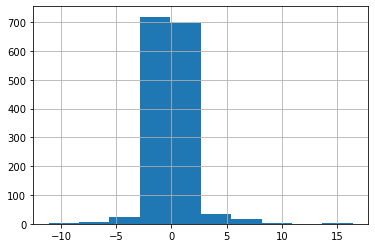

In [97]:
# Plot histogram of residuals

y_train_resid.hist()
plt.xlabel = "Residuals"
plt.ylabel = "Frequency"
plt.title = "Best Model, Training Residuals"

# Don't delete the code below 👇
plt.savefig("images/3-5-14.png", dpi=150)


In [98]:
with open("images/3-5-14.png", "rb") as file:
    wqet_grader.grade("Project 3 Assessment", "Task 3.5.14", file)

**Task 3.5.15:** Create an ACF plot for `y_train_resid`. Be sure to label the x-axis as `"Lag [hours]"` and y-axis as `"Correlation Coefficient"`. Use the title `"Dar es Salaam, Training Residuals ACF"`.

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

# Don't delete the code below 👇
plt.savefig("images/3-5-15.png", dpi=150)


In [ ]:
with open("images/3-5-15.png", "rb") as file:
    wqet_grader.grade("Project 3 Assessment", "Task 3.5.15", file)

## Evaluate

**Task 3.5.16:** Perform walk-forward validation for your model for the entire test set `y_test`. Store your model's predictions in the Series `y_pred_wfv`. Make sure the name of your Series is `"prediction"` and the name of your Series index is `"timestamp"`.

In [104]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history, lags=28).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred) # series can append
    history = history.append(y_test[next_pred.index]) #dont append the whole y_test, use the timestamp using .index
    
y_pred_wfv.name = "prediction"
y_pred_wfv.index.name = "timestamp"
y_pred_wfv.head()

/tmp/ipykernel_222/874113537.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_pred_wfv = pd.Series()


timestamp
2018-03-06 00:00:00+03:00    8.056391
2018-03-06 01:00:00+03:00    8.681779
2018-03-06 02:00:00+03:00    6.268951
2018-03-06 03:00:00+03:00    6.303760
2018-03-06 04:00:00+03:00    7.171444
Freq: H, Name: prediction, dtype: float64

In [105]:

wqet_grader.grade("Project 3 Assessment", "Task 3.5.16", y_pred_wfv)

**Task 3.5.17:** Submit your walk-forward validation predictions to the grader to see test mean absolute error for your model.

In [107]:
wqet_grader.grade("Project 3 Assessment", "Task 3.5.17", y_pred_wfv)

# Communicate Results

**Task 3.5.18:** Put the values for `y_test` and `y_pred_wfv` into the DataFrame `df_pred_test` (don't forget the index). Then plot `df_pred_test` using plotly express. Be sure to label the x-axis as `"Date"` and the y-axis as `"PM2.5 Level"`. Use the title `"Dar es Salaam, WFV Predictions"`.

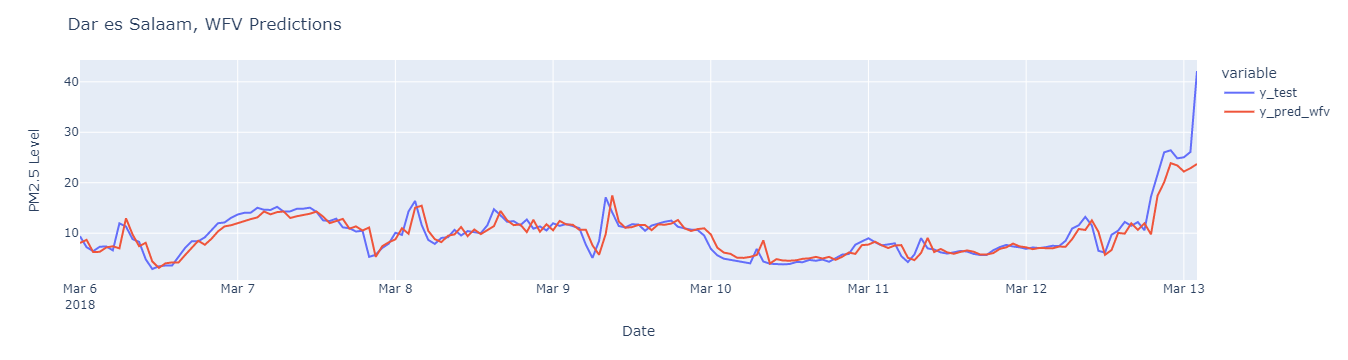

In [108]:
df_pred_test = pd.DataFrame(
    {
        "y_test": y_test, "y_pred_wfv": y_pred_wfv
    }
)
fig = px.line(df_pred_test, labels={"value": "PM2.5"})
fig.update_layout(
    title="Dar es Salaam, WFV Predictions",
    xaxis_title="Date",
    yaxis_title="PM2.5 Level",
)
# Don't delete the code below 👇
fig.write_image("images/3-5-18.png", scale=1, height=500, width=700)

fig.show()

In [109]:
with open("images/3-5-18.png", "rb") as file:
    wqet_grader.grade("Project 3 Assessment", "Task 3.5.18", file)

---
Copyright © 2022 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
